In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('..\\data\\data.xlsx')
data.reset_index(drop=True, inplace=True)

In [3]:
data

,ID,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,2,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,3,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,4,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,5,0.83,Ideal,G,SI1,EX,EX,GIA,3171
...,...,...,...,...,...,...,...,...,...
5995,5996,1.03,Ideal,D,SI1,EX,EX,GIA,6250
5996,5997,1.00,Very Good,D,SI1,VG,VG,GIA,5328
5997,5998,1.02,Ideal,D,SI1,EX,EX,GIA,6157
5998,5999,1.27,Signature-Ideal,G,VS1,EX,EX,GIA,11206


In [57]:
print(data.info())
print('-------------------------------------------')
print(f'{data.duplicated().sum(): 20}')
print('-------------------------------------------')
print(f'{data.isna().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            6000 non-null   int64  
 1   Carat Weight  6000 non-null   float64
 2   Cut           6000 non-null   object 
 3   Color         6000 non-null   object 
 4   Clarity       6000 non-null   object 
 5   Polish        6000 non-null   object 
 6   Symmetry      6000 non-null   object 
 7   Report        6000 non-null   object 
 8   Price         6000 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 422.0+ KB
None
-------------------------------------------
                   0
-------------------------------------------
ID              0
Carat Weight    0
Cut             0
Color           0
Clarity         0
Polish          0
Symmetry        0
Report          0
Price           0
dtype: int64


In [4]:
train_data = data.drop('ID', axis=1)

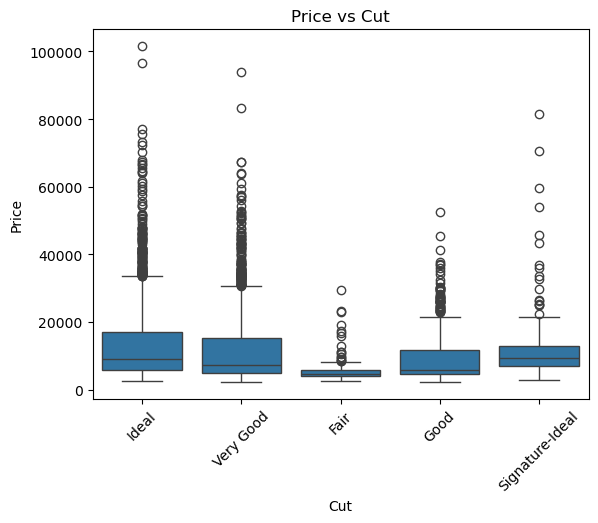

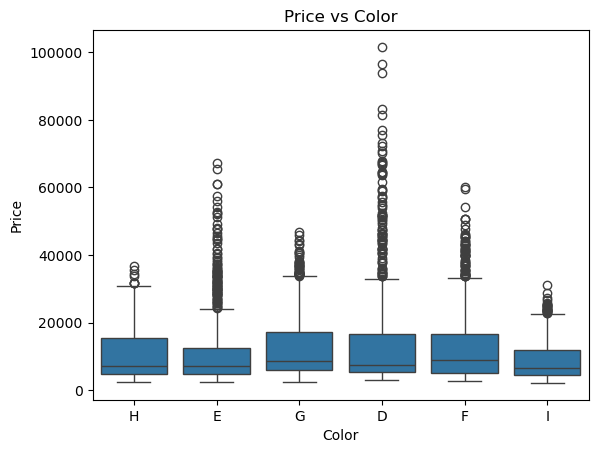

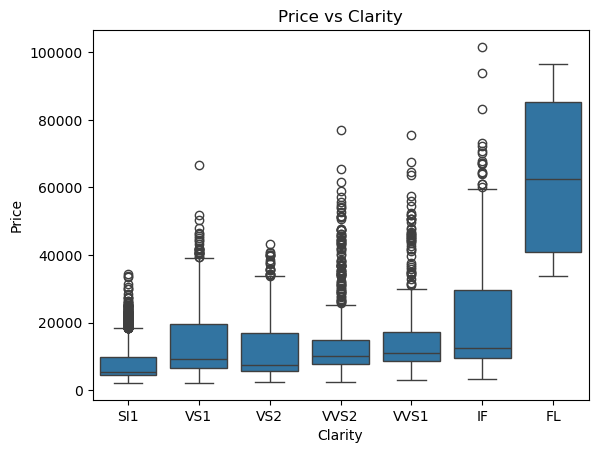

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cut vs Price
sns.boxplot(x='Cut', y='Price', data=train_data)
plt.title('Price vs Cut')
plt.xticks(rotation=45)
plt.show()

# Color vs Price
sns.boxplot(x='Color', y='Price', data=train_data)
plt.title('Price vs Color')
plt.show()

# Clarity vs Price
sns.boxplot(x='Clarity', y='Price', data=train_data)
plt.title('Price vs Clarity')
plt.show()


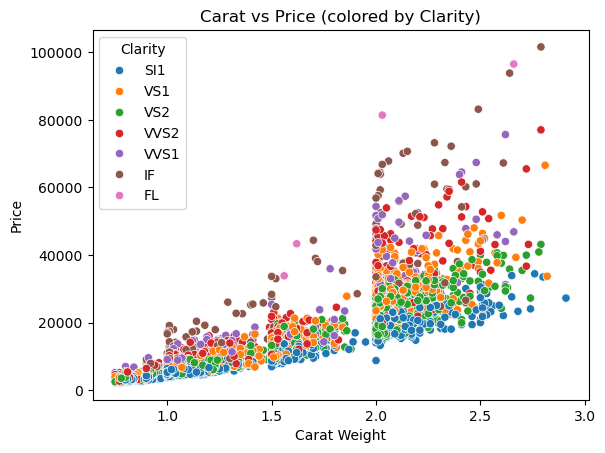

In [64]:
sns.scatterplot(x='Carat Weight', y='Price', hue='Clarity', data=train_data)
plt.title('Carat vs Price (colored by Clarity)')
plt.show()


In [107]:
train_data['Clarity'].value_counts()

Clarity
SI1     2059
VS2     1575
VS1     1192
VVS2     666
VVS1     285
IF       219
FL         4
Name: count, dtype: int64

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# Обозначаем фичи которые хотим энкодить
categorical_columns = ['Cut', 'Color', 'Clarity', 'Polish', 'Symmetry', 'Report']
numerical_columns = ['Carat Weight']


# Разбиваем на X, y для обучения
X = train_data.drop('Price', axis=1)
y = train_data['Price']


# Создаем трансформер
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns),
        ('num', 'passthrough', numerical_columns)
    ]
)

# Делаем новый X. 
X_encoded = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=1984)
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [82]:
# Что бы увидеть как выглядят таблица после энкодинга 
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)
final_feature_names = list(encoded_feature_names) + numerical_columns
final_feature_names

['Cut_Good',
 'Cut_Ideal',
 'Cut_Signature-Ideal',
 'Cut_Very Good',
 'Color_E',
 'Color_F',
 'Color_G',
 'Color_H',
 'Color_I',
 'Clarity_IF',
 'Clarity_SI1',
 'Clarity_VS1',
 'Clarity_VS2',
 'Clarity_VVS1',
 'Clarity_VVS2',
 'Polish_G',
 'Polish_ID',
 'Polish_VG',
 'Symmetry_G',
 'Symmetry_ID',
 'Symmetry_VG',
 'Report_GIA',
 'Carat Weight']

In [7]:
prediction = model.predict(X_encoded)

In [8]:
train_data['Predicted'] = prediction
train_data['value_score'] = train_data['Predicted'] / train_data['Price']

In [9]:
#Лучшие варинант если смотрим с Огрнакой уровня "Идеально"
train_data[(train_data['value_score'] > 1) & (train_data['Cut'] == 'Signature-Ideal') & (train_data['Clarity'] == 'IF')]

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price,Predicted,value_score
3330,1.51,Signature-Ideal,G,IF,ID,ID,AGSL,18806,19043.587500,1.012634
4730,2.06,Signature-Ideal,I,IF,ID,ID,AGSL,25354,28158.258333,1.110604


In [10]:
# Лучшие варианты если смотрим по недооцености камня по мнение модели 
train_data.sort_values(by='value_score', ascending=False).head(5)


,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price,Predicted,value_score
2995,1.91,Very Good,F,IF,G,G,GIA,28557,46295.22,1.621151
971,2.43,Ideal,I,IF,EX,EX,GIA,25897,40869.96,1.578174
5985,2.43,Ideal,I,IF,EX,VG,GIA,26638,40648.73,1.525968
4529,2.31,Ideal,I,IF,EX,EX,GIA,24817,37774.21,1.522110
448,1.62,Signature-Ideal,F,VS1,ID,ID,AGSL,19661,29001.57,1.475081


In [11]:
# Предсказания
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Метрики
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Для train
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Для test
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train MAE: {mae_train:.2f}, R²: {r2_train:.4f}")
print(f"Test  MAE: {mae_test:.2f}, R²: {r2_test:.4f}")


Train MAE: 321.14, R²: 0.9954
Test  MAE: 763.74, R²: 0.9723


In [12]:
# Добавил проверку метрик что бы понимать, что модель не переобучилась и посмотреть метрики насколько можно довериять модели 


y_pred = model.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")


MAE:  763.74
RMSE: 1647.52
R²:   0.9723


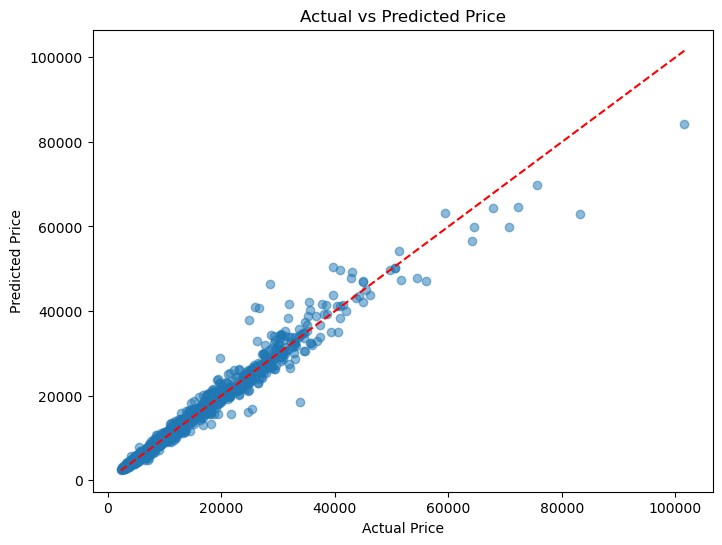

In [13]:
# Визуализация предиктов модели и что модель хорошо обобщает 
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()


In [39]:
#Просто эксперимент для проверки модели. Модель и с ручной настройокй хорошо работает



# from xgboost import XGBRegressor
# import optuna
# from sklearn.model_selection import cross_val_score

# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 700),
#         'max_depth': trial.suggest_int('max_depth', 3, 5),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 0.5),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 0.5),
#         "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
#         "eval_metric": 'mae',
#         "early_stopping_rounds": 25,
#         'random_state': 1984
#     }

#     X_t, X_v, y_t, y_v = train_test_split(X_encoded, y, test_size=0.3, random_state=1984)
    
#     model = XGBRegressor(**params)

#     model.fit(
#         X_t, y_t,
#         eval_set=[(X_v, y_v)],
#         verbose=True
#     )

#     preds = model.predict(X_v)
#     mae = mean_absolute_error(y_v, preds)
#     return mae


In [41]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=55)

# print(study.best_params)
# print(study.best_value)

# best_model = XGBRegressor(**study.best_params)
# best_model.fit(X_train, y_train)

# best_predict = best_model.predict(X_test)

# print(f'MAE: {mean_absolute_error(y_test, best_predict): 2f}')
# print(f'RMSE: {np.sqrt(mean_squared_error(y_test, best_predict)): 2f}')
# print(f'R2: {r2_score(y_test, best_predict): 4f}')

MAE:  685.748783
RMSE:  1443.916905
R2:  0.978725


In [42]:
y_pred_xgb = xgb_model.predict(X_test)

print(f'MAE: {mean_absolute_error(y_test, y_pred_xgb): 2f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)): 2f}')
print(f'R2: {r2_score(y_test, y_pred_xgb): 4f}')

MAE:  688.807886
RMSE:  1416.195825
R2:  0.979534


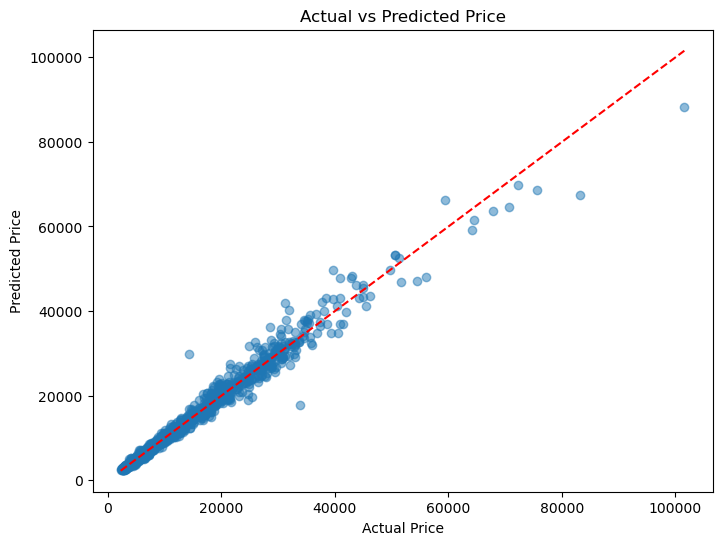

In [16]:
# Визуализация предиктов модели и что модель хорошо обобщает 
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()

# Сильной разницы между XGBRegressor и RandomForestRegressor нету


In [17]:
prediction_gxb = model.predict(X_encoded)
train_data['Predicted_xgb'] = prediction_gxb
train_data['value_score_xgb'] = train_data['Predicted_xgb'] / train_data['Price']

In [43]:
#Топ 1 бриллиант все тот же

train_data.sort_values('value_score_xgb', ascending=False).head(10) 

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price,Predicted,value_score,Predicted_xgb,value_score_xgb
2995,1.91,Very Good,F,IF,G,G,GIA,28557,46295.220000,1.621151,46295.220000,1.621151
971,2.43,Ideal,I,IF,EX,EX,GIA,25897,40869.960000,1.578174,40869.960000,1.578174
5985,2.43,Ideal,I,IF,EX,VG,GIA,26638,40648.730000,1.525968,40648.730000,1.525968
4529,2.31,Ideal,I,IF,EX,EX,GIA,24817,37774.210000,1.522110,37774.210000,1.522110
448,1.62,Signature-Ideal,F,VS1,ID,ID,AGSL,19661,29001.570000,1.475081,29001.570000,1.475081
3306,1.12,Fair,G,VS1,VG,G,GIA,5487,7921.277143,1.443644,7921.277143,1.443644
4684,1.01,Fair,H,VS2,VG,VG,GIA,4030,5738.840000,1.424030,5738.840000,1.424030
1641,2.00,Very Good,H,SI1,EX,EX,GIA,8803,11547.796667,1.311802,11547.796667,1.311802
3134,2.00,Ideal,E,VVS2,VG,VG,GIA,31924,41584.582500,1.302612,41584.582500,1.302612
5778,0.75,Ideal,I,VS2,EX,EX,GIA,2520,3232.232000,1.282632,3232.232000,1.282632


In [48]:
from sklearn.pipeline import Pipeline
import pickle



# 🎯 1. Подготовка данных
categorical_cols = ['Cut', 'Color', 'Clarity', 'Polish', 'Symmetry', 'Report']
numerical_cols = ['Carat Weight']
target = 'Price'

X = data[categorical_cols + numerical_cols]
y = data[target]

# 🎯 2. Построим pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

best_model = XGBRegressor(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    learning_rate=study.best_params['learning_rate'],
    subsample=study.best_params['subsample'],
    colsample_bytree=study.best_params['colsample_bytree'],
    gamma=study.best_params['gamma'],
    reg_alpha=study.best_params['reg_alpha'],
    reg_lambda=study.best_params['reg_lambda'],
    eval_metric='mae',
    random_state=1984,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', best_model)
])

# 🎯 3. Обучение и сохранение
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1984)
pipeline.fit(X_train, y_train)

# ✅ Сохраняем модель
with open('diamond_price_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)